In [2]:
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats
import statsmodels.api as sm
from itertools import product

import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## Подготовка данных

In [4]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')

In [5]:
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price['Year']= df_price['Date'].dt.year
df_price['Month'] = df_price['Date'].dt.month
df_price['year_month'] = df_price['Year'].astype(str) + '_' +\
                         df_price['Month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)

In [6]:
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)
df_price['Name_ID'] = df_price['player_name'] + "_" +  df_price['player_id'].astype(str)

In [7]:
df_merge=pd.merge(df_price,df_stats,on='player_id', how='inner')
df_merge_revision_normal=df_merge[df_merge.revision=='Normal']

In [8]:
#df_merge_revision_normal.groupby(['Name_ID','year_month'])['price'].max().reset_index()
df_merge_revision_normal.groupby(['name','year_month',])['price'].mean().sort_values(ascending=False)

name               year_month
Cristiano Ronaldo  2017_01       1.709007e+06
                   2016_12       1.569421e+06
                   2017_02       1.513418e+06
                   2016_09       1.502000e+06
                   2017_03       1.470011e+06
                   2016_10       1.435849e+06
                   2016_11       1.387468e+06
                   2017_04       1.158901e+06
Messi              2016_09       1.148048e+06
                   2016_10       8.892648e+05
                   2017_01       7.988225e+05
                   2016_12       7.818563e+05
Cristiano Ronaldo  2017_06       7.740405e+05
                   2017_05       7.708267e+05
Messi              2016_11       7.459091e+05
                   2017_02       6.788329e+05
                   2017_03       6.760159e+05
Suárez             2016_09       6.428911e+05
                   2016_10       5.655601e+05
Messi              2017_04       5.438579e+05
Ibrahimovic        2017_01       5.433125e+05
Neym

In [9]:
df_Messi=df_merge_revision_normal[df_merge_revision_normal.name=='Messi']
df_Messi.shape

(270, 85)

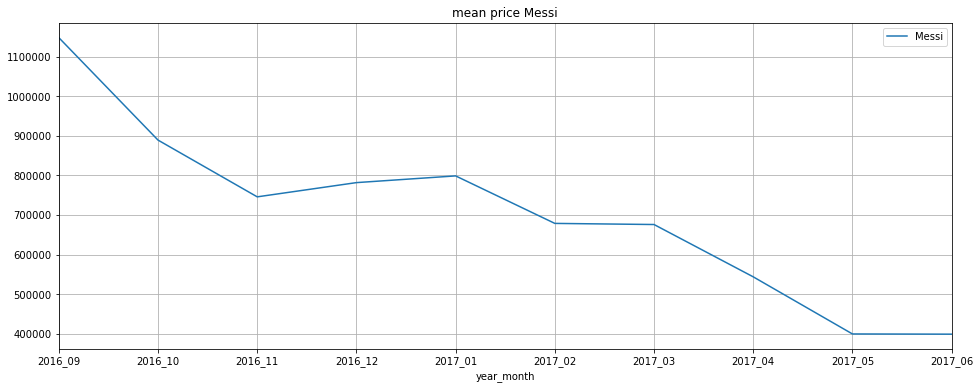

In [10]:
plt.figure(figsize=(16,6))
#df_merge_revision_normal.groupby('year_month')['price'].max().plot(label='all football players')
df_Messi.groupby('year_month')['price'].mean().plot(label='Messi')
plt.title('mean price Messi')
plt.legend()
plt.grid()

## <center>Messi</center>

In [11]:
df=df_Messi[['Date','price']]
df.shape

(270, 2)

In [12]:
df = df.groupby('Date')[['price']].mean()
df.head()

,price
Date,
2016-09-23,1477500
2016-09-24,1204419
2016-09-25,1233438
2016-09-26,1126719
2016-09-27,1146559


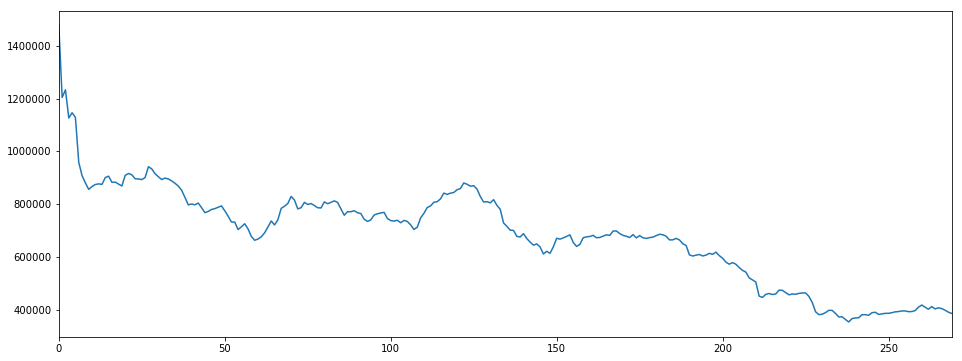

In [26]:
#plotly_df(df.resample('W').apply(sum), title = 'mean price Messi per week')
plt.figure(figsize=(16,6))
df['y'].plot()

# Прогноз
* ## Prophet

In [480]:
#df=df_merge_revision_normal[['Date','price']]
#df = df.groupby('Date')[['price']].mean()

In [14]:
predictions = 30

df = df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
265,2017-06-15,406806
266,2017-06-16,404118
267,2017-06-17,397944
268,2017-06-18,390694
269,2017-06-19,385732


In [15]:
train_df = df[:-predictions] 

In [16]:
m = Prophet()
m.fit(train_df)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [17]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
265,2017-06-15
266,2017-06-16
267,2017-06-17
268,2017-06-18
269,2017-06-19


In [18]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,seasonal,yhat
265,2017-06-15,1.108787,244553.689443,-185.888623,-185.888623,227621.394711,262022.520311,168863.703065,320866.468356,-185.888623,-185.888623,-185.888623,-185.888623,244367.800820
266,2017-06-16,1.112971,239657.827684,16309.159608,16309.159608,221305.976818,258090.557014,179680.110339,331378.344171,16309.159608,16309.159608,16309.159608,16309.159608,255966.987292
267,2017-06-17,1.117155,234761.965925,-514.222682,-514.222682,214935.015100,254319.830156,163895.113631,314167.711059,-514.222682,-514.222682,-514.222682,-514.222682,234247.743242
268,2017-06-18,1.121339,229866.104165,-7137.780820,-7137.780820,208820.608375,250514.804750,143528.091682,299051.228007,-7137.780820,-7137.780820,-7137.780820,-7137.780820,222728.323346
269,2017-06-19,1.125523,224970.242406,-7013.550574,-7013.550574,202567.331142,247195.387869,140517.268280,294078.351179,-7013.550574,-7013.550574,-7013.550574,-7013.550574,217956.691832


In [19]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, seasonal, yhat


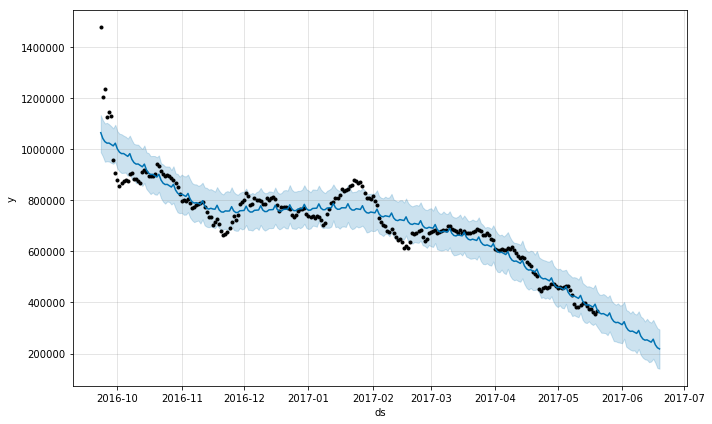

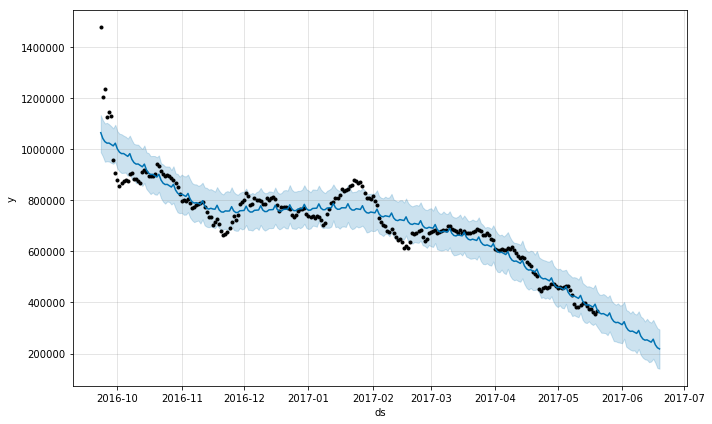

In [20]:
m.plot(forecast)

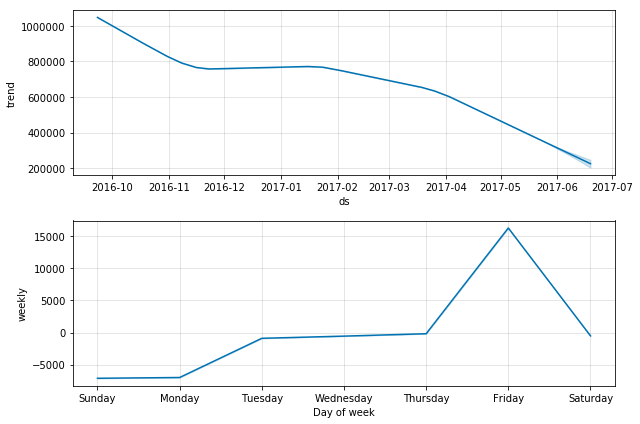

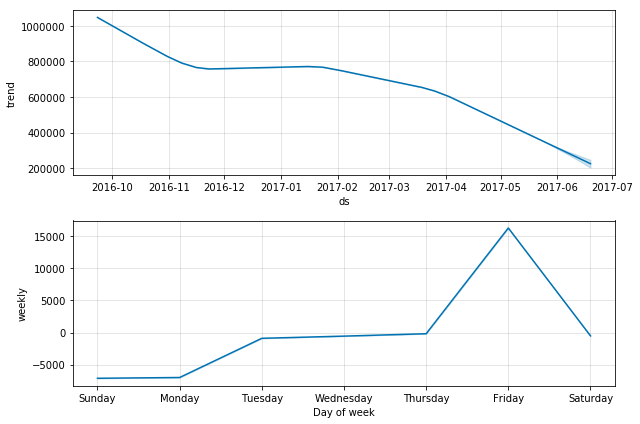

In [21]:
m.plot_components(forecast)

In [22]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [23]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 24.43499012373224
MAE 97068.40646291428


In [27]:
def show_forecast(cmp_df, num_predictions, num_values):

    forecast = go.Scatter(
        name='Prophet',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )


    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )


    data = [forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='price'),
        title='price Messi',
        showlegend = True)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 200)

* ## BoxCox

In [28]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [29]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(23.50828418515641, 93383.26678214339)

* ## ARIMA

In [32]:
#train_df = df.fillna(df.y.mean()).set_index('ds')
#train_df = df.set_index('ds')

#df=df_Messi[['Date','price']]

#df = df.groupby('Date')[['price']].mean()
df=df.set_index('ds')
df.head()

,y
ds,
2016-09-23,1477500
2016-09-24,1204419
2016-09-25,1233438
2016-09-26,1126719
2016-09-27,1146559


In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


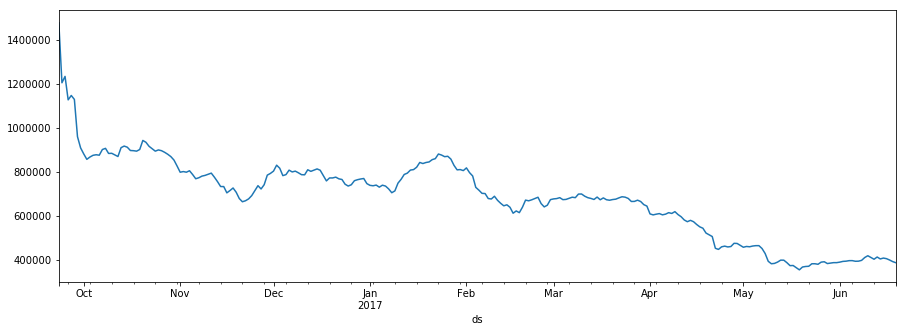

In [34]:
plt.figure(figsize(15,5))
df['y'].plot()

### STL-декомпозиция ряда 

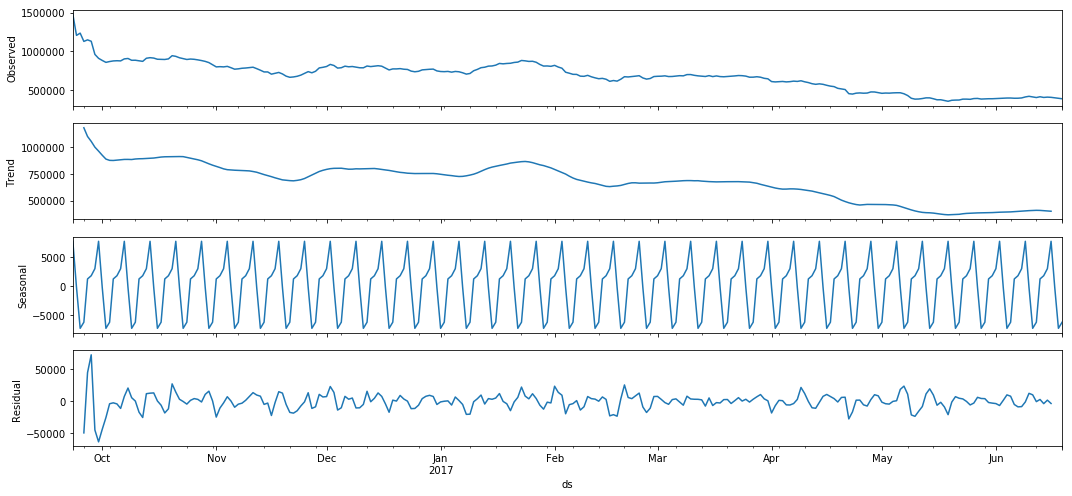

In [35]:
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df['y']).plot()
pylab.show()

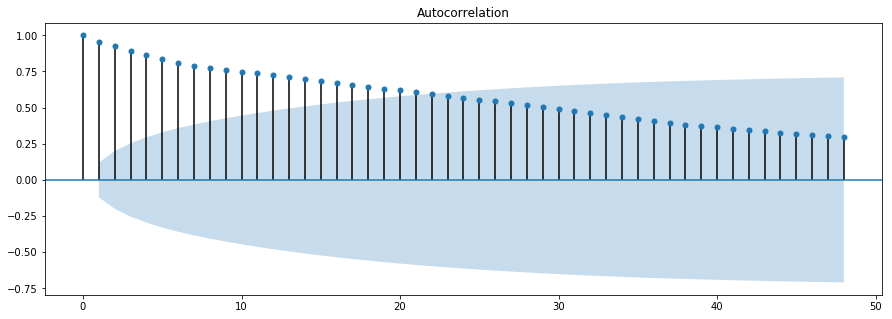

In [36]:
plt.figure(figsize(15,5))
sm.graphics.tsa.plot_acf(df['y'].values, lags=48)
pylab.show()

### Проверка ряда на стационарность

In [37]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])

Критерий Дики-Фуллера: p=0.899885


### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.840593
Критерий Дики-Фуллера: p=0.909746


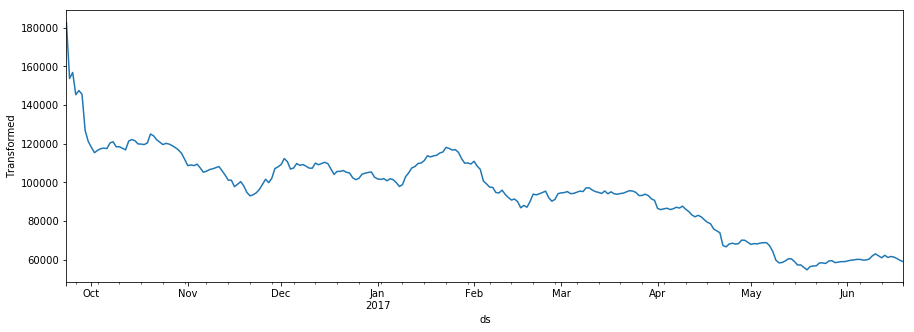

In [38]:
df['y_box'], lmbda = stats.boxcox(df.y)

plt.figure(figsize(15,5))
df.y_box.plot()

plt.ylabel(u'Transformed')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_box)[1])

### Избавляемся от тренда и сезонности

Критерий Дики-Фуллера: p=0.001510


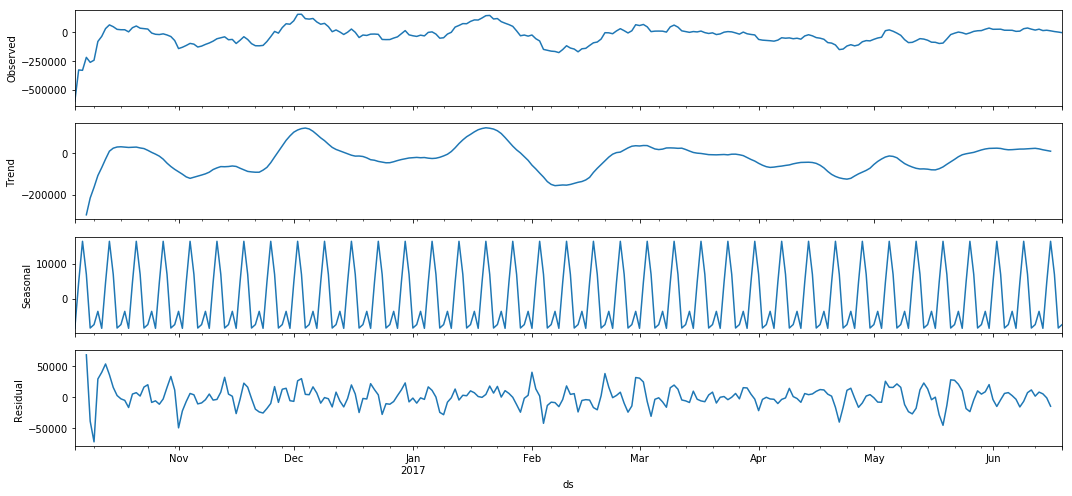

In [39]:
df['y_diff'] = df.y - df.y.shift(12)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df.y_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000046


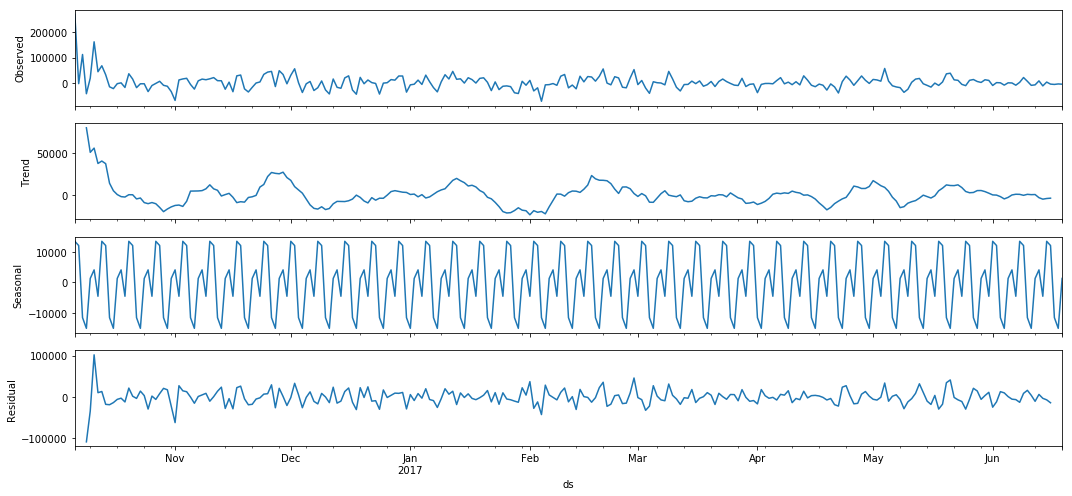

In [40]:
df['y_diff2'] = df.y_diff - df.y_diff.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df.y_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_diff2[13:])[1])

Критерий Дики-Фуллера: p=0.000000


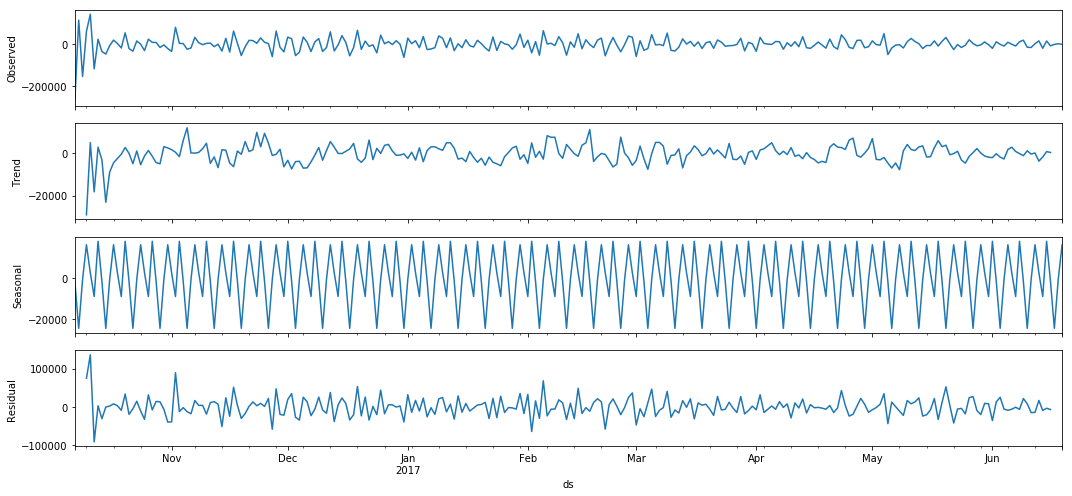

In [41]:
df['y_diff3'] = df.y_diff2 - df.y_diff2.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(df.y_diff3[14:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.y_diff3[14:])[1])

####  ряд стационарен (p-value=0.000000)

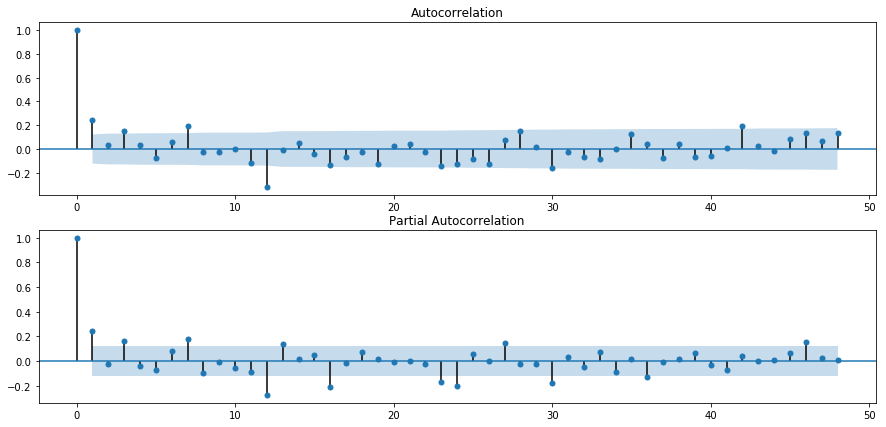

In [42]:
plt.figure(figsize(15,7))
#ACF 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.y_diff2[14:].values.squeeze(), lags=48, ax=ax)
#PACF
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.y_diff2[14:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=2 (не уверен в правильности параметров)

In [43]:
ps = range(0, 3)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [44]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Количество параметров: {}".format(len(parameters_list)))

Количество параметров: 24


### подбор параметров

In [45]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['y'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 23.7 s


In [46]:
best_param

(2, 1, 1, 1)

In [47]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
22  (2, 1, 1, 1)  5922.706501
10  (1, 0, 1, 1)  5937.363162
6   (0, 1, 1, 1)  5937.615419
18  (2, 0, 1, 1)  5939.638884
14  (1, 1, 1, 1)  5941.118457


In [48]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  270
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2955.353
Date:                            Fri, 30 Jun 2017   AIC                           5922.707
Time:                                    23:03:23   BIC                           5944.297
Sample:                                09-23-2016   HQIC                          5931.376
                                     - 06-19-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7303      0.042     17.366      0.000       0.648       0.813
ar.L2          0.0832      0.015   

## остатки

Критерий Стьюдента: p=0.075373
Критерий Дики-Фуллера: p=0.000040


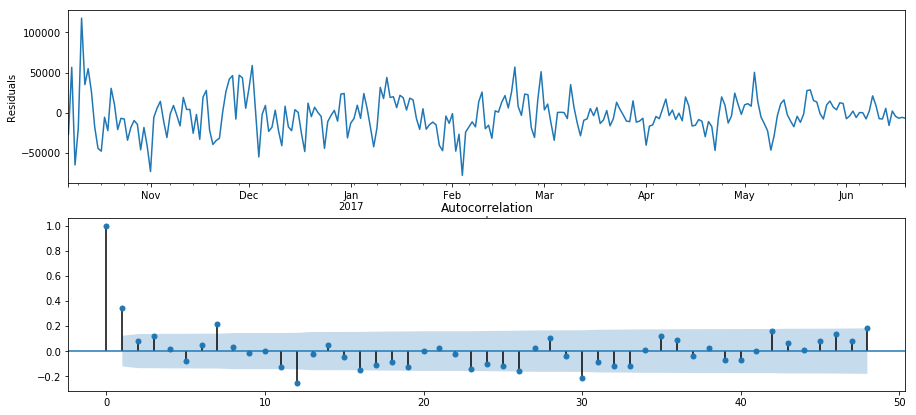

In [49]:
plt.figure(figsize(15,7))
plt.subplot(211)

best_model.resid[14:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[14:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[14:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[14:])[1])

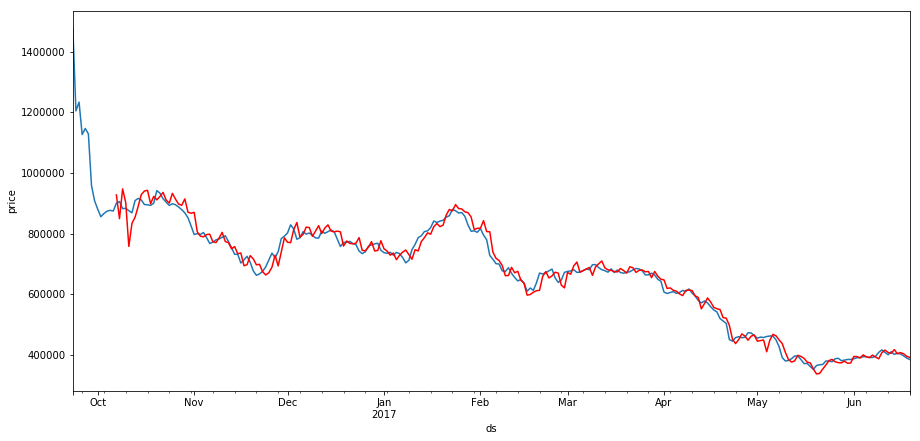

In [50]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

#data['model'] = invboxcox(best_model.fittedvalues, lmbda)
df['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
df.y.plot()
df.model[14:].plot(color='r')
plt.ylabel('price')
pylab.show()

In [51]:
df.iloc[-1]

y          385732.000000
y_box       59046.737850
y_diff      -6969.000000
y_diff2     -5357.000000
y_diff3      -975.000000
model      392621.520655
Name: 2017-06-19 00:00:00, dtype: float64

In [52]:
df.tail()

,y,y_box,y_diff,y_diff2,y_diff3,model
ds,,,,,,
2017-06-15,406806,61746.933282,14132.0,2984.0,15056.0,404616.882335
2017-06-16,404118,61403.786077,9055.0,-5077.0,-8061.0,408580.530960
2017-06-17,397944,60614.236876,2770.0,-6285.0,-1208.0,404708.858773
2017-06-18,390694,59684.587007,-1612.0,-4382.0,1903.0,396371.279574
2017-06-19,385732,59046.737850,-6969.0,-5357.0,-975.0,392621.520655


In [53]:
270+30

300

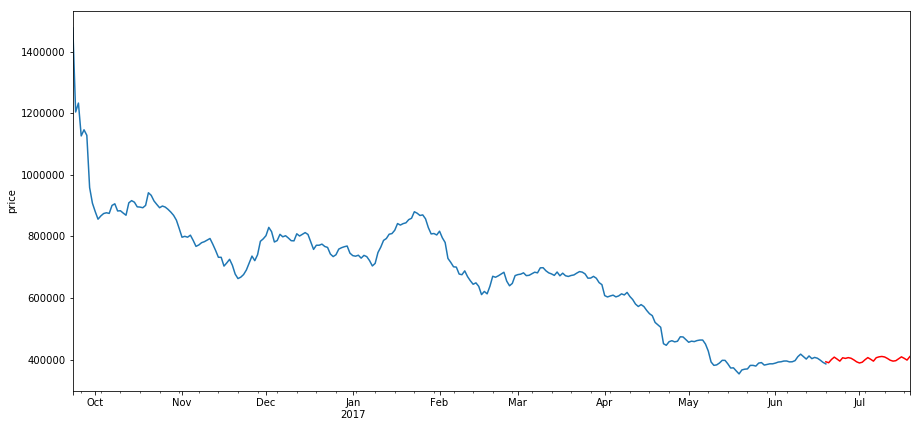

In [70]:
#Строим прогноз на 30 дней вперед
df2 = df[['y']]
date_list = [datetime.datetime.strptime("2017-06-20", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,30)]
future = pd.DataFrame(index=date_list, columns = df.columns)
df2 = pd.concat([df2, future])

df2['forecast'] = best_model.predict(start=269, end=303)

plt.figure(figsize(15,7))
df2.y.plot()
df2.forecast.plot(color='r')
plt.ylabel('price')
pylab.show()

In [68]:
df2.tail()

,model,y,y_box,y_diff,y_diff2,y_diff3,forecast
2017-06-16,NaN,404118,NaN,NaN,NaN,NaN,NaN
2017-06-17,NaN,397944,NaN,NaN,NaN,NaN,NaN
2017-06-18,NaN,390694,NaN,NaN,NaN,NaN,NaN
2017-06-19,NaN,385732,NaN,NaN,NaN,NaN,392621.520655
2017-06-20,NaN,NaN,NaN,NaN,NaN,NaN,389509.089438


## Линейные модели

In [45]:
df=df_Messi[['Date','price']]
df = df.groupby('Date')[['price']].mean()
df.head()

,price
Date,
2016-09-23,1477500
2016-09-24,1204419
2016-09-25,1233438
2016-09-26,1126719
2016-09-27,1146559


In [47]:
#df = df.reset_index()
#df.columns = ['ds', 'y']
#df.tail()

In [48]:
###df=df.set_index('ds')
#dataset=df
#dataset.head()

In [14]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [46]:
data = pd.DataFrame(df.copy())
data.columns = ["y"]

data.index = data.index.to_datetime()
#data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,y,weekday,is_weekend
Date,,,
2016-09-23,1477500,4,0
2016-09-24,1204419,5,1
2016-09-25,1233438,6,1
2016-09-26,1126719,0,0
2016-09-27,1146559,1,0


In [49]:
code_mean(data, 'weekday', "y")

{0: 673001.48717948713,
 1: 676197.84615384613,
 2: 673758.641025641,
 3: 671855.69230769225,
 4: 701927.92307692312,
 5: 684428.66666666663,
 6: 675629.66666666663}

In [51]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
    data.index = data.index.to_datetime()
    #data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    #data['weekday_average'] = map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)
    #data["hour_average"] = map(code_mean(data[:test_index], 'hour', "y").get, data.hour)

    # выкидываем закодированные средними признаки 
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [53]:
from sklearn.linear_model import LinearRegression

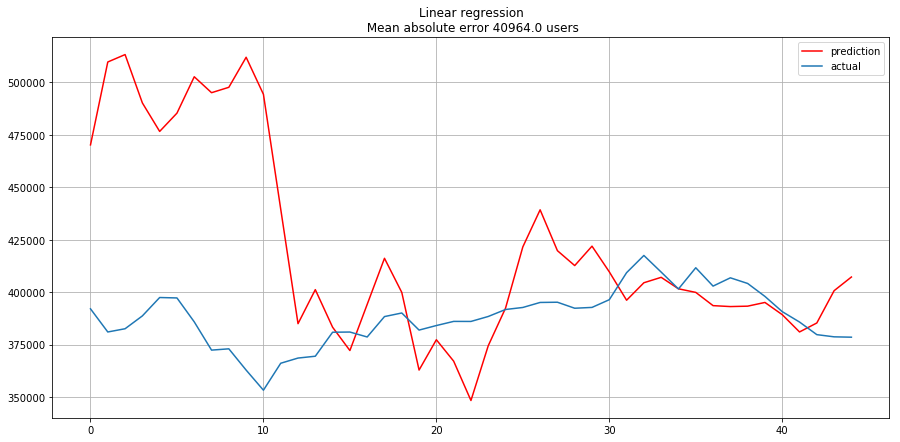

In [68]:
X_train, X_test, y_train, y_test = prepareData(dataset.y, test_size=0.3, lag_start=12, lag_end=38)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [57]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    
    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [58]:
performTimeSeriesCV(X_train, y_train, 10, lr, mean_absolute_error)

Size train set: (192, 37)
Size of each fold: 19

Splitting the first 2 chunks at 1/2
Size of train + test: (38, 37)

Splitting the first 3 chunks at 2/3
Size of train + test: (57, 37)

Splitting the first 4 chunks at 3/4
Size of train + test: (76, 37)

Splitting the first 5 chunks at 4/5
Size of train + test: (95, 37)

Splitting the first 6 chunks at 5/6
Size of train + test: (114, 37)

Splitting the first 7 chunks at 6/7
Size of train + test: (133, 37)

Splitting the first 8 chunks at 7/8
Size of train + test: (152, 37)

Splitting the first 9 chunks at 8/9
Size of train + test: (171, 37)

Splitting the first 10 chunks at 9/10
Size of train + test: (190, 37)


95987.386953004083